# 7 Chemception

Molecular features as images

In the Graph representation we build a matrix represetationa of each molecualr where the integer in each i,j coordinate represetned the type of bond.

Building an image is quite similar, we build a matrix, but that matrix represents the locaton of atoms in 2d space, and teh integer is the type of element. So 1 matrix total, not one matrix per elemental type.

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
def import_data():
    # data cleaning - not all chembl entries are created equal
    df = pd.read_table('../23_1_qsar/lib/data/2_hiv_protease.tsv')
    # some entries are missing label values
    df = df[df['Standard Value'] > 0]
    # there are duplicate values, let's get the mean Ki per smiles
    df = pd.DataFrame( df.groupby(['Smiles'])['Standard Value'].mean() )
    # now the Ki values are very diverse, let's take the log10 transform
    data = {'smiles': df['Standard Value'].index,
            'pKi': df['Standard Value'].values}
    df = pd.DataFrame(data)
    return df
df = import_data()
smiles = df.smiles

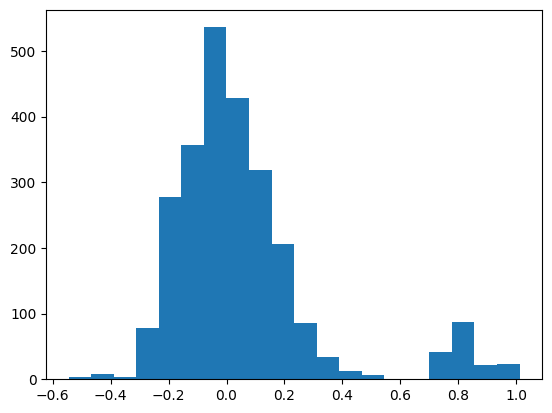

In [6]:
# now we scale y to between -1 and 1
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
rbs = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(5.0, 95.0), copy=True)
df['y'] = rbs.fit_transform(np.log(df.pKi.values.reshape(-1,1)))
h = plt.hist(df['y'], bins=20)

# chemcepterise images

https://www.cheminformania.com/learn-how-to-teach-your-computer-to-see-chemistry-free-chemception-models-with-rdkit-and-keras/

In [7]:
#' functionm to generate clean molecular images
from rdkit.Chem import AllChem
from rdkit import Chem

def chemcepterize_mol(mol, embed=12.0, res=0.5):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims,4))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2)) #
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            vect[ idx , idy, 1] = atom.GetAtomicNum()
            #Gasteiger Charges
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy, 3] = charge
            #Hybridization
            hyptype = atom.GetHybridization().real
            vect[ idx , idy, 2] = hyptype
    return vect[:,:,:]

This coped fundtion from the website does a few things, let's break them down.
 - 

In [8]:
df["mol"] = df["smiles"].apply(AllChem.MolFromSmiles)

(48, 48, 4)


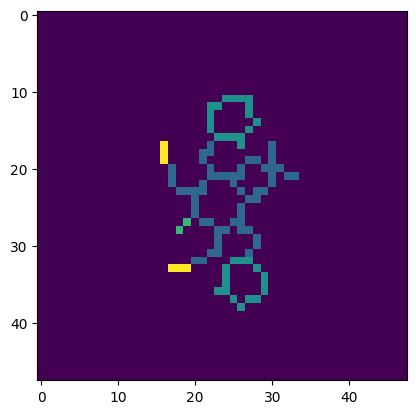

In [9]:
import matplotlib.pyplot as plt
mol = df['mol'][0]
v = chemcepterize_mol(mol, embed=12, res=0.5)
print(v.shape)
plt.imshow(v[:,:,0])

In [10]:
# mols that are too large fail, weed them out
def mol2maxpos(mol):
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    max_pos = np.max(cmol.GetConformer(0).GetPositions())
    return(max_pos)

df["mol"] = df["smiles"].apply(AllChem.MolFromSmiles)

df["max_pos"] = df["mol"].apply(mol2maxpos)
df = df[df['max_pos'] < 9.5]
df.shape

(1711, 5)

In [11]:
from multiprocessing import Pool
import os

# Let's see if we can do this for a bunch
with Pool(processes=os.cpu_count()) as p:
    chemcepterize_mols = np.stack(p.map(chemcepterize_mol, df.mol))
chemcepterize_mols

array([[[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
 

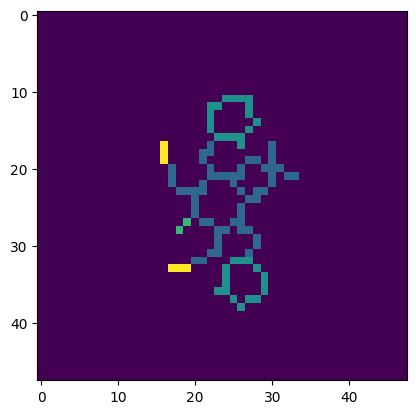

In [12]:
plt.imshow(chemcepterize_mols[0,:,:,0])

In [13]:
import tensorflow as tf  
from tensorflow import keras
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    chemcepterize_mols,
    df['y'].values,
    test_size=0.2,
    random_state=123)

2023-06-23 08:22:15.655176: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-23 08:22:16.492460: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-23 08:22:16.508447: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 08:22:19.998690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
# samples, height, width, channels
input_shape = x_train.shape[1:]
print(input_shape)
print(y_train.shape)

(48, 48, 4)
(1368,)


In [15]:
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Input, GlobalMaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
print("Keras: %s"%keras.__version__)

Keras: 2.12.0


In [16]:
def Inception0(input):
    tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)
    tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)
    tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
    return output

def Inception(input):
    tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)
    tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)
    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
    tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
    return output

input_img = Input(shape=input_shape)
x = Inception0(input_img)
x = Inception(x)
od=int(x.shape[1])
x = MaxPooling2D(pool_size=(od,od), strides=(1,1))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='linear')(x)
model = Model(inputs=input_img, outputs=output)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 16)   80          ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 48, 48, 16)   80          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 48, 48, 16)   2320        ['conv2d[0][0]']                 
                                                                                              

In [17]:
optimizer = Adam(lr=0.00025)
model.compile(loss="mse", optimizer=optimizer)

/home/oscar/.local/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(rotation_range=180,
                               width_shift_range=0.1,height_shift_range=0.1,
                               fill_mode="constant",cval = 0,
                               horizontal_flip=True, vertical_flip=True,data_format='channels_last',
                               )
#Concatenate for longer epochs
Xt = np.concatenate([x_train]*2, axis=0)
yt = np.concatenate([y_train]*2, axis=0)
batch_size=128
g = generator.flow(Xt, yt, batch_size=batch_size, shuffle=True)
#steps_per_epoch = 10000/batch_size
steps_per_epoch = 10/batch_size

In [19]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=1e-6, verbose=1)
history = model.fit(g,
                              steps_per_epoch=len(Xt)//batch_size,
                              epochs=20,
                              validation_data=(x_test,
                                               y_test),
                              callbacks=[reduce_lr])

2023-06-23 08:22:51.365152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/20


2023-06-23 08:23:02.576807: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56623104 exceeds 10% of free system memory.
2023-06-23 08:23:03.571407: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56623104 exceeds 10% of free system memory.
2023-06-23 08:23:07.675708: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56623104 exceeds 10% of free system memory.
2023-06-23 08:23:11.659498: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33177600 exceeds 10% of free system memory.
2023-06-23 08:23:11.824622: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56623104 exceeds 10% of free system memory.


21/21 [==============================] - 129s 5s/step - loss: 0.0827 - val_loss: 0.0560 - lr: 2.5000e-04
Epoch 2/20
21/21 [==============================] - 83s 4s/step - loss: 0.0510 - val_loss: 0.0364 - lr: 2.5000e-04
Epoch 3/20
21/21 [==============================] - 94s 4s/step - loss: 0.0481 - val_loss: 0.0362 - lr: 2.5000e-04
Epoch 4/20
21/21 [==============================] - 82s 4s/step - loss: 0.0463 - val_loss: 0.0373 - lr: 2.5000e-04
Epoch 5/20
21/21 [==============================] - 86s 4s/step - loss: 0.0469 - val_loss: 0.0373 - lr: 2.5000e-04
Epoch 6/20
21/21 [==============================] - 86s 4s/step - loss: 0.0455 - val_loss: 0.0393 - lr: 2.5000e-04
Epoch 7/20
21/21 [==============================] - 86s 4s/step - loss: 0.0457 - val_loss: 0.0377 - lr: 2.5000e-04
Epoch 8/20
12/21 [================>.............] - ETA: 37s - loss: 0.0467

KeyboardInterrupt: 

In [21]:
name = "Chemception_std_notebook_demo"
model.save("%s.h5"%name)
hist = history.history
import pickle
pickle.dump(hist, file("%s_history.pickle"%name,"w"))
#from keras.model import load_model
#model = load_model("%s.h5"%name)

NameError: name 'history' is not defined

In [22]:
for label in ['val_loss','loss']:
    plt.plot(hist[label], label = label)
plt.legend()
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss/lr")

NameError: name 'hist' is not defined

In [ ]:
# remember, always plot.
y_test_pred = rbs.inverse_transform(model.predict(x_test))
plt.plot(y_test, y_test_pred, 'o', color='black');
plt.xlabel('true ki');
plt.ylabel('predicted ki');